# Seasonal range of tracer concentrations, T, S, age


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
from cosima_cookbook import explore

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.path as mpath
from matplotlib import ticker, cm
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
import glob,os
import climtas.nci
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmcrameri
import gsw


import cartopy.crs as ccrs
import cartopy.feature as cfeature

import sys
sys.path.append("/g/data/x77/ps7863/python_scripts")
import helper_functions as helper

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)


from dask.distributed import Client

figdir = '/g/data/x77/ps7863/figures/AABW_variability/'

In [2]:
climtas.nci.GadiClient()

<Client: 'tcp://127.0.0.1:36179' processes=48 threads=48, memory=190.00 GiB>

In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
expt = '01deg_jra55v140_iaf_cycle3_antarctic_tracers'

In [4]:
lon_slice = slice(-70, 80)
lat_slice = slice(-82, -55)

degree =  u'\N{DEGREE SIGN}'

In [5]:
ht = cc.querying.getvar(iaf_cycle3,'ht',session, n=1) 
ht = ht.sel(yt_ocean = lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

In [6]:
shelf_mask = ht > 1000
shelf_mask = shelf_mask.astype(bool)
masked_shelf = shelf_mask.where(shelf_mask==0, np.nan)
shelf_mask = shelf_mask.where(shelf_mask==1, np.nan)
shelf_mask

<xarray.DataArray 'ht' (yt_ocean: 584, xt_ocean: 1500)> Size: 7MB
dask.array<where, shape=(584, 1500), dtype=float64, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -69.95 -69.85 -69.75 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -55.07 -55.01

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [8]:
land_50m = cfeature.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="grey", linewidth=0.5
)

In [9]:
xt_ocean = ht.xt_ocean
yt_ocean = ht.yt_ocean

In [10]:
X, Y = np.meshgrid(xt_ocean, yt_ocean)
X = xr.DataArray(X, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])
Y = xr.DataArray(Y, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])

In [11]:
def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """

    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(
        boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[1, ::-1], latitudes[1, ::-1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[:, 1], latitudes[:, 1]]), axis=1
    )
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

In [12]:
# To plot 1000-m contour
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf[np.where(shelf!=0)] = np.nan
shelf = shelf+1
shelf = np.nan_to_num(shelf)
shelf = xr.DataArray(shelf, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

In [13]:
first_year = 1958
last_year = 2018
start_time = f'01-01-{first_year}'
end_time = f'31-12-{last_year}'
time_slice = slice(start_time, end_time)

# Tracer concentrations

In [14]:
wsbw = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/WSBW_tracer_bottom_500_1958-2018.nc')
pbbw = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/PBBW_tracer_bottom_500_1958-2018.nc')
wsbw = wsbw['WSBW tracer']
pbbw = pbbw['PBBW tracer']

In [15]:
wsbw_clim = wsbw.groupby('time.month').mean('time')
pbbw_clim = pbbw.groupby('time.month').mean('time')

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


In [16]:
where_nan = np.isnan(wsbw_clim.sel(month=1))
wsbw_clim = wsbw_clim.where(~where_nan,0)
where_nan = np.isnan(pbbw_clim.sel(month=1))
pbbw_clim = pbbw_clim.where(~where_nan,0)

In [17]:
wsbw_peak_month = wsbw_clim.argmax('month')+1
pbbw_peak_month = pbbw_clim.argmax('month')+1

In [18]:
wsbw_range = wsbw_clim.max('month') - wsbw_clim.min('month')
pbbw_range = pbbw_clim.max('month') - pbbw_clim.min('month')

In [19]:
wsbw_mean = helper.annual_mean_from_monthly(wsbw)
pbbw_mean = helper.annual_mean_from_monthly(pbbw)


In [20]:
# normalise seasonal range by the time-mean concentration (result in %)
wsbw_range = wsbw_range / wsbw_mean * 100
pbbw_range = pbbw_range / pbbw_mean * 100

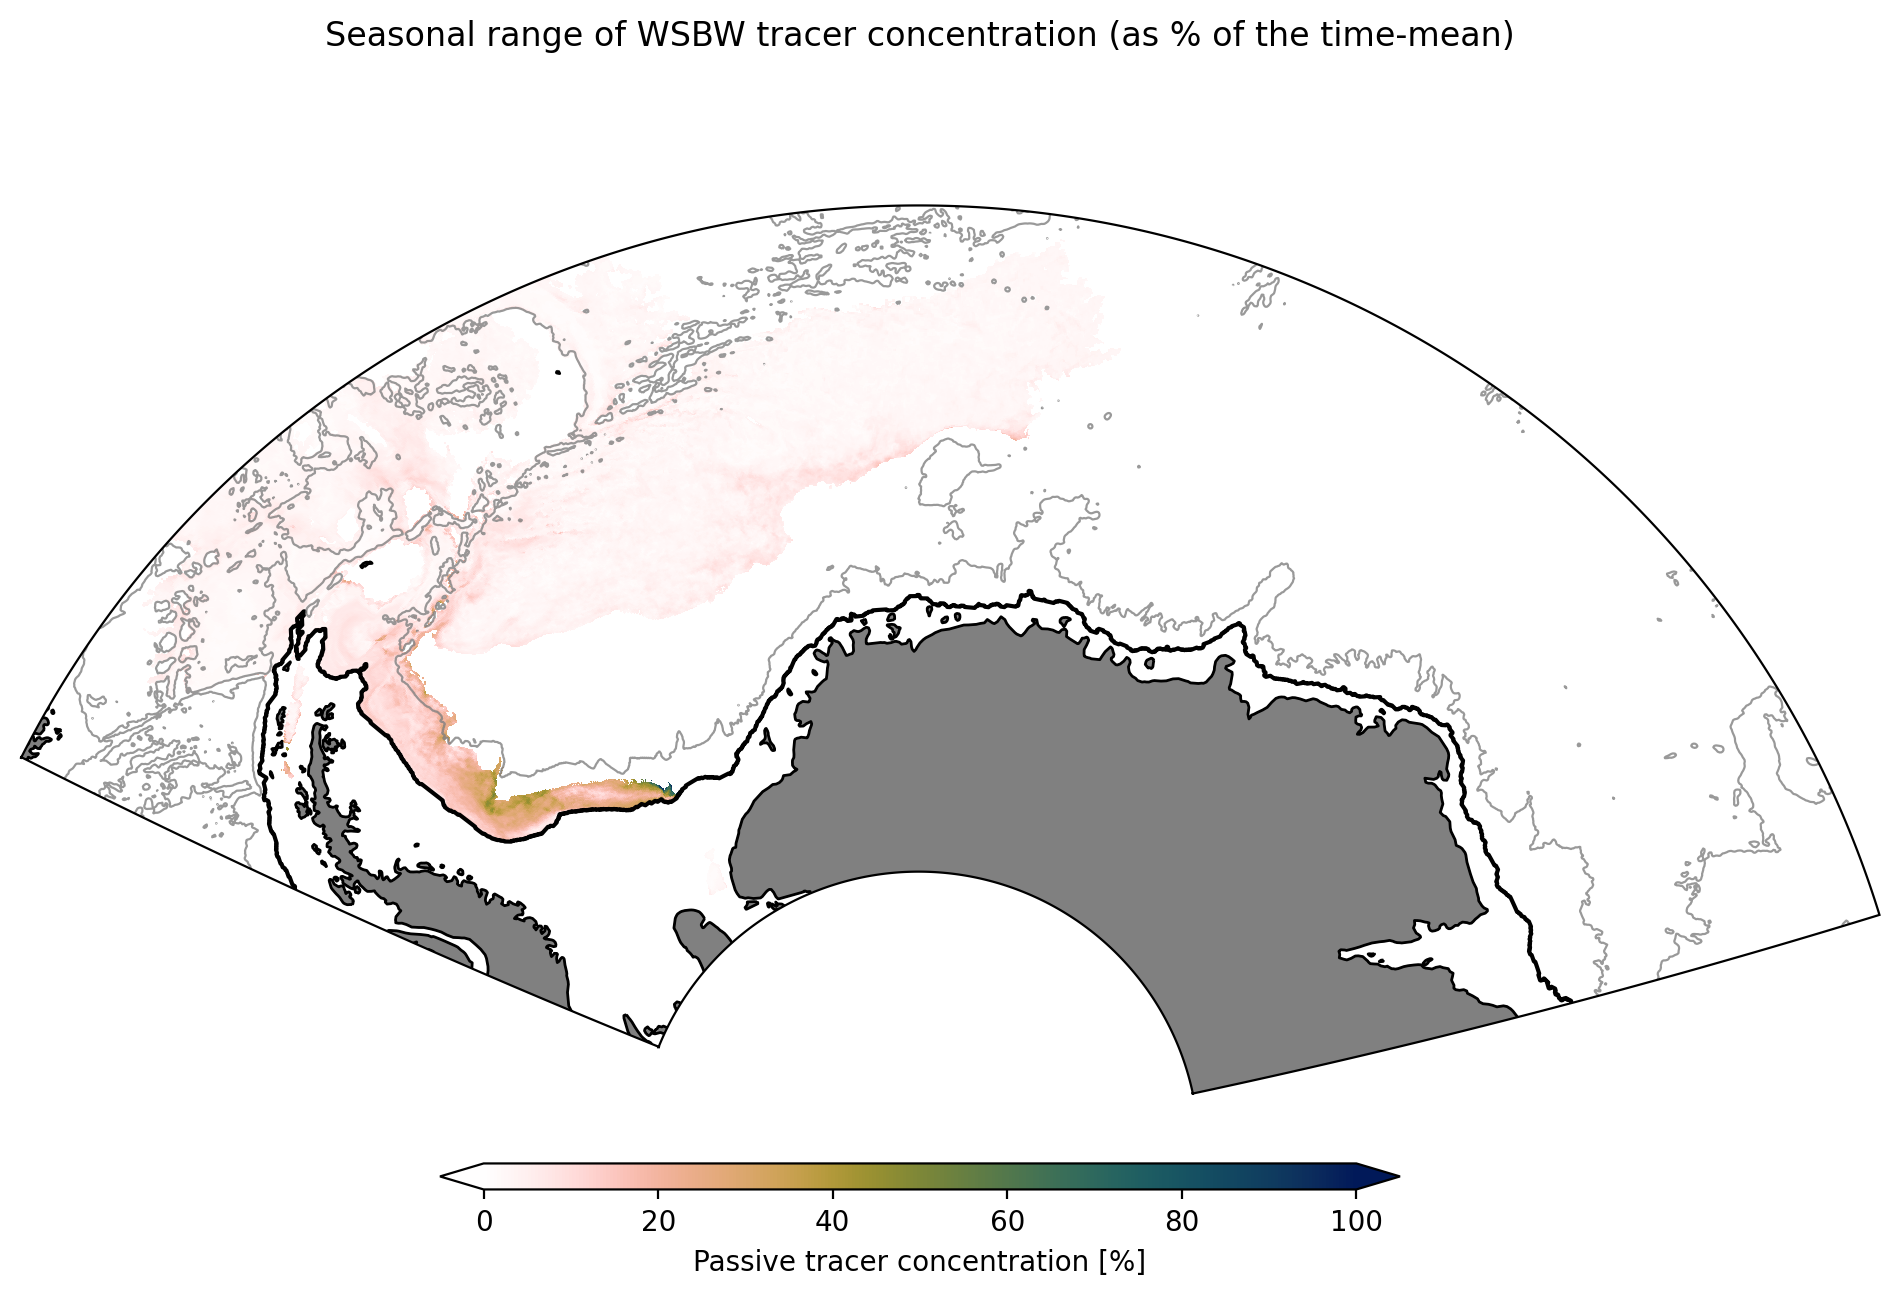

In [51]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())


ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=50, vmax=100)
cmap = cmcrameri.cm.batlowW_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, wsbw_range.where(wsbw_mean >= 0.05)*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label(f'Passive tracer concentration [%]')

plt.suptitle('Seasonal range of WSBW tracer concentration (as % of the time-mean)')

plt.savefig(f'{figdir}/wsbw_range_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


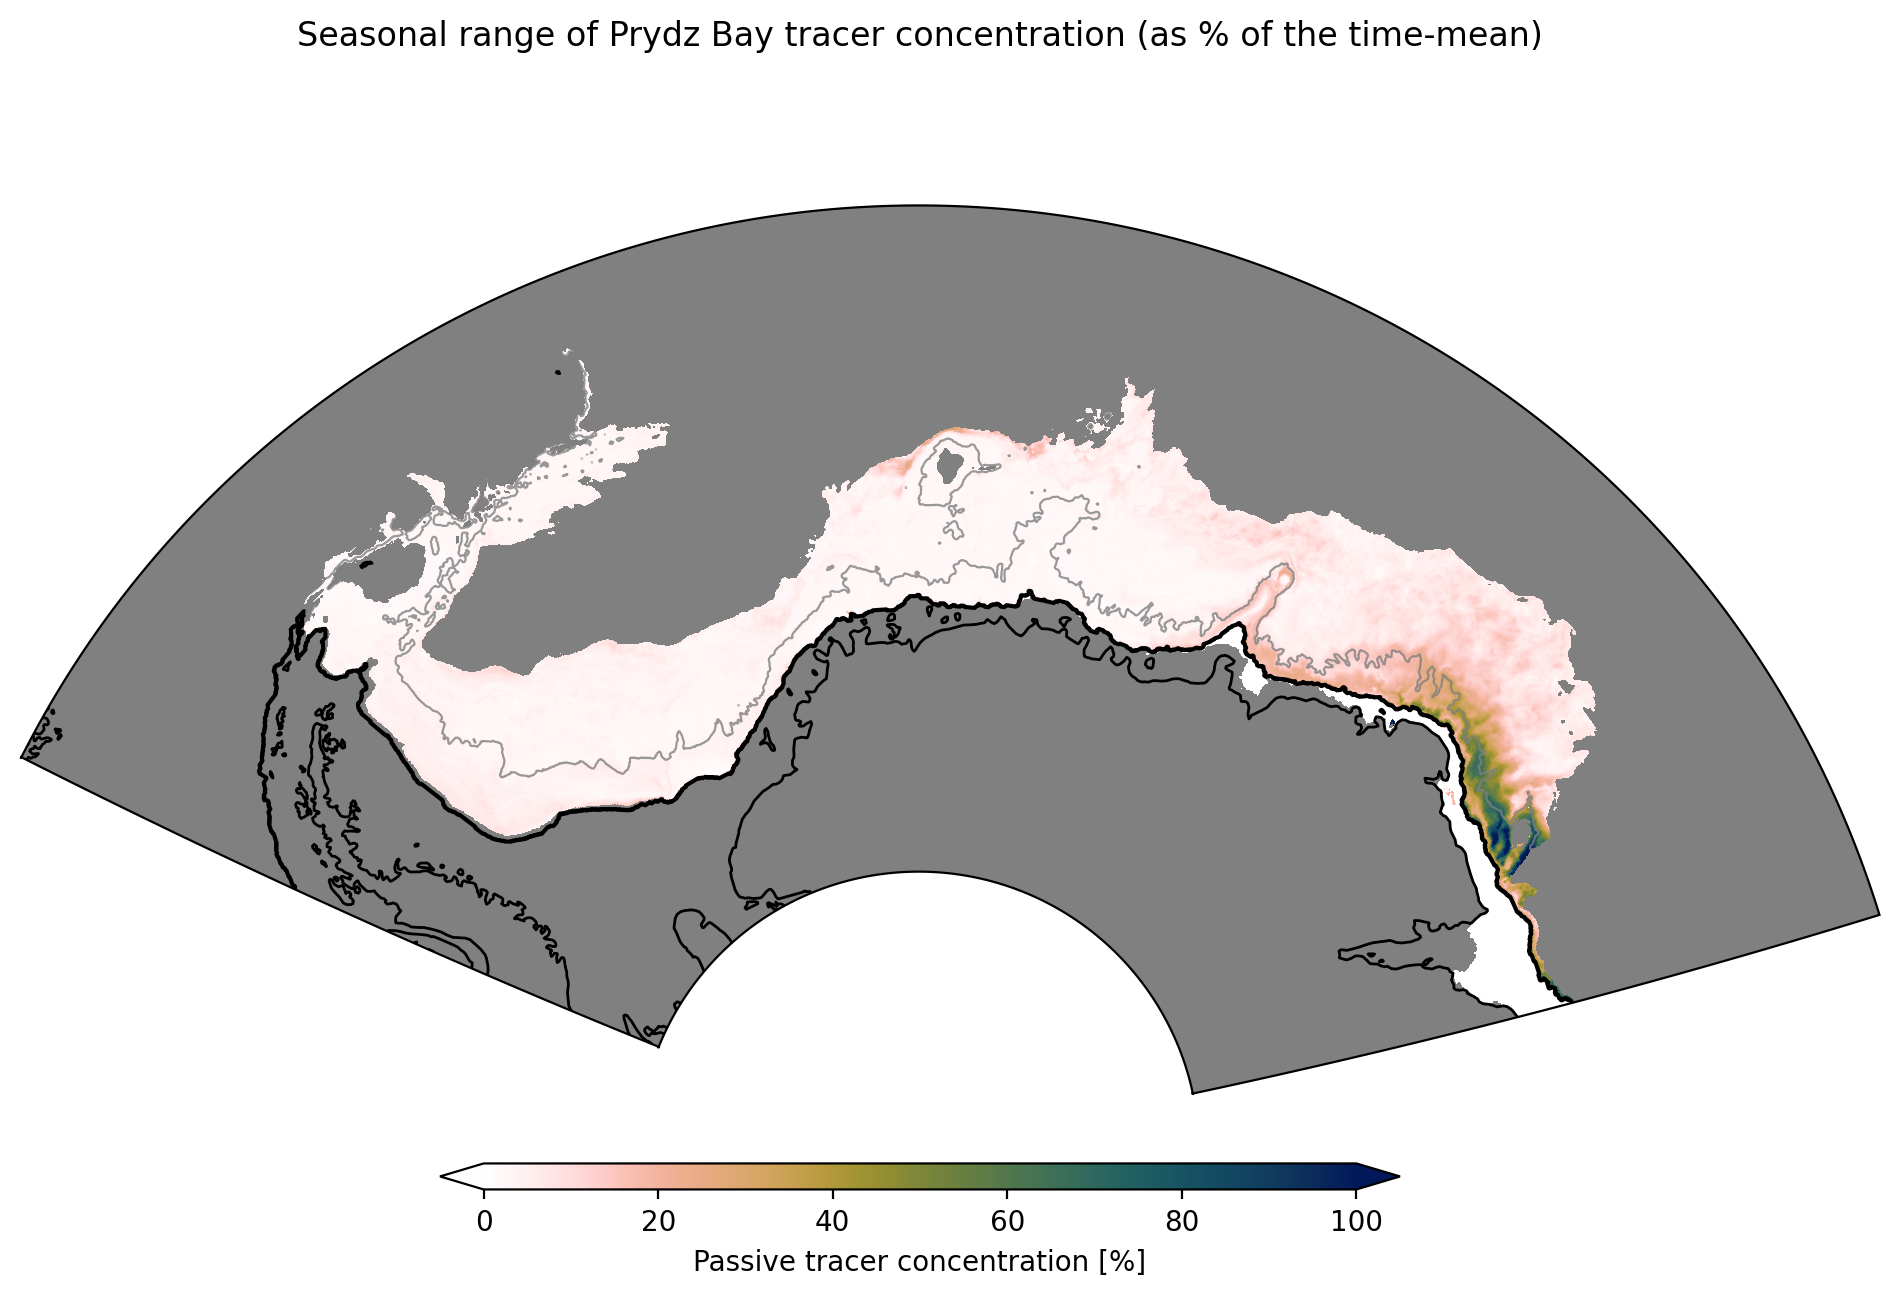

In [23]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())


ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())


norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=50, vmax=100)
cmap = cmcrameri.cm.batlowW_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, (pbbw_range*shelf_mask).where(pbbw_mean>=0.05), cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label(f'Passive tracer concentration [%]')

ax.contourf(ht.xt_ocean+360, ht.yt_ocean, mask, levels=[0.5, 1.5], colors='grey', transform=ccrs.PlateCarree())

plt.suptitle('Seasonal range of Prydz Bay tracer concentration (as % of the time-mean)')


plt.savefig(f'{figdir}/prydz_range_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


In [22]:
mask = pbbw_mean >= 0.05
mask = np.where(mask, np.nan, 1)


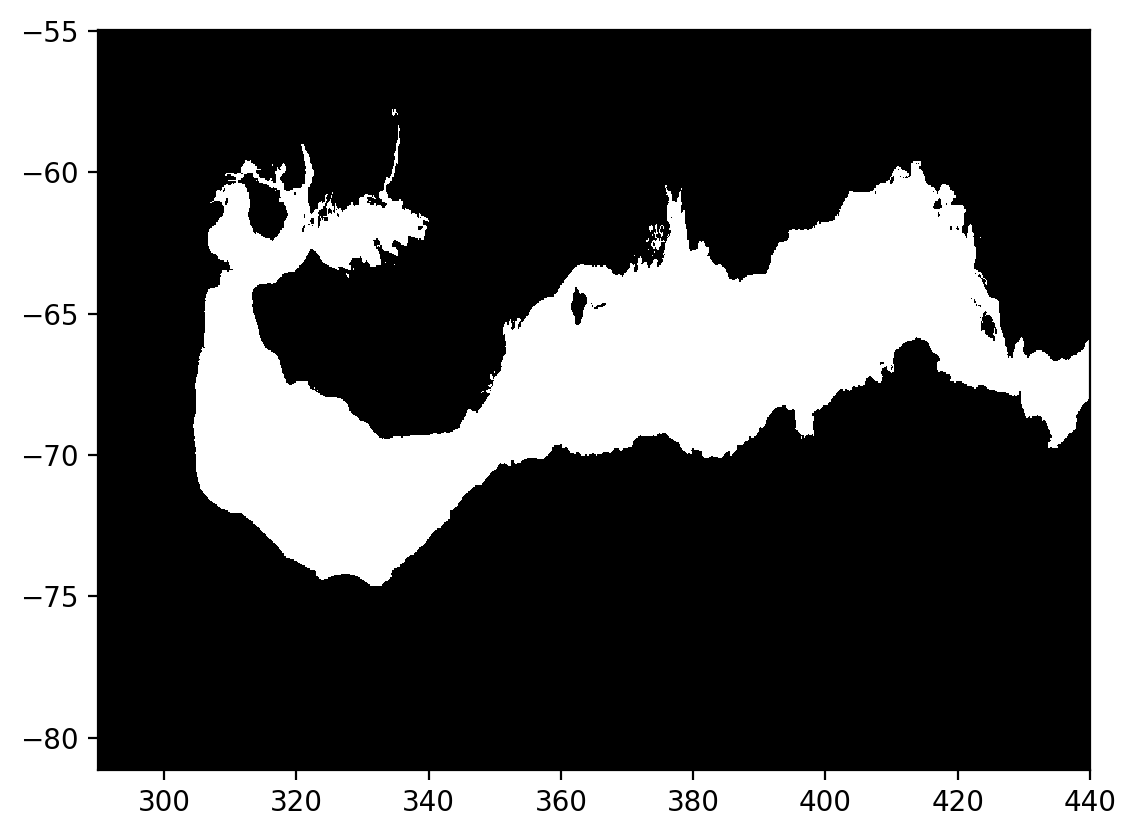

In [47]:
plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, mask, cmap='Greys_r')


In [41]:
temp = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/temperature_westAA_in_the_bottom_500m_1958-2018.nc')
salt = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/salinity_westAA_in_the_bottom_500m_1958-2018.nc')
age = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/age_westAA_in_the_bottom_500m_1958-2018.nc')
sigma2 = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/sigma2_westAA_in_the_bottom_500m_1958-2018.nc')

In [43]:
temp = temp['__xarray_dataarray_variable__']
salt = salt['__xarray_dataarray_variable__']
age = age['__xarray_dataarray_variable__']
sigma = sigma2['__xarray_dataarray_variable__']

In [16]:
temp = temp.sel(xt_ocean=lon_slice, yt_ocean=lat_slice)
salt = salt.sel(xt_ocean=lon_slice, yt_ocean=lat_slice)
age = age.sel(xt_ocean=lon_slice, yt_ocean=lat_slice)
sigma = sigma.sel(xt_ocean=lon_slice, yt_ocean=lat_slice)

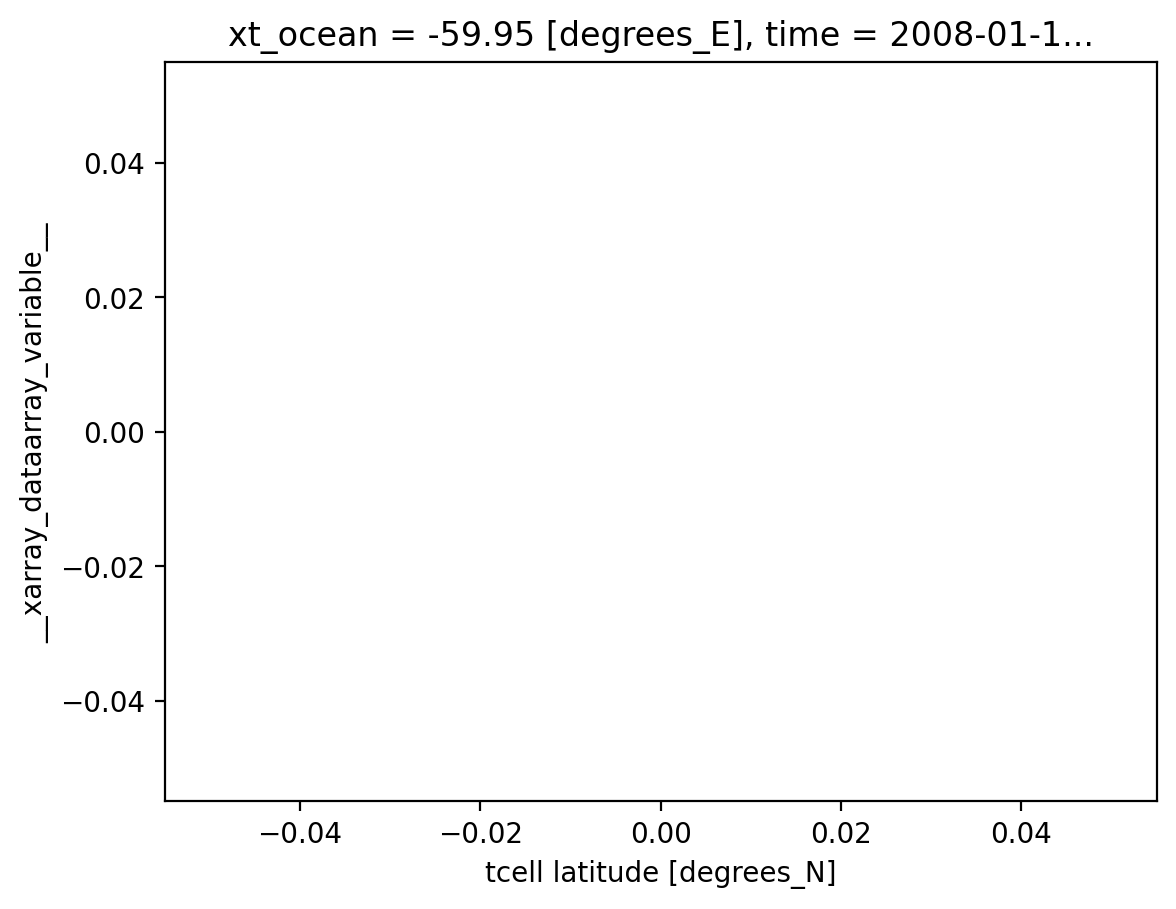

In [46]:
age.isel(time=600, xt_ocean=100).plot()

In [17]:
age_clim = age.groupby('time.month').mean('time')
salt_clim = salt.groupby('time.month').mean('time')
temp_clim = temp.groupby('time.month').mean('time')
sigma_clim = sigma.groupby('time.month').mean('time') 

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


In [18]:
age_range = (age_clim.max(dim='month') - age_clim.min(dim='month')).load()
salt_range = (salt_clim.max(dim='month') - salt_clim.min(dim='month')).load()
temp_range = (temp_clim.max(dim='month') - temp_clim.min(dim='month')).load()
sigma2_range = (sigma_clim.max(dim='month') - sigma_clim.min(dim='month')).load()

In [19]:
def add_colorbar(ax, data, ticks=None, extend=None):
    fontsize = 12
    axins = inset_axes(ax, width = "3%", height = "100%", loc = 'lower left',
                   bbox_to_anchor = (1.02, 0., 1, 1), bbox_transform = ax.transAxes,
                   borderpad = 0)
    cbar = fig.colorbar(data, cax = axins, ticks=ticks, extend=extend)
    return cbar

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [22]:
land_50m = cfeature.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="grey", linewidth=0.5
)

In [23]:
xt_ocean = ht.xt_ocean
yt_ocean = ht.yt_ocean

In [24]:
X, Y = np.meshgrid(xt_ocean, yt_ocean)
X = xr.DataArray(X, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])
Y = xr.DataArray(Y, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])

In [25]:
def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """

    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(
        boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[1, ::-1], latitudes[1, ::-1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[:, 1], latitudes[:, 1]]), axis=1
    )
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

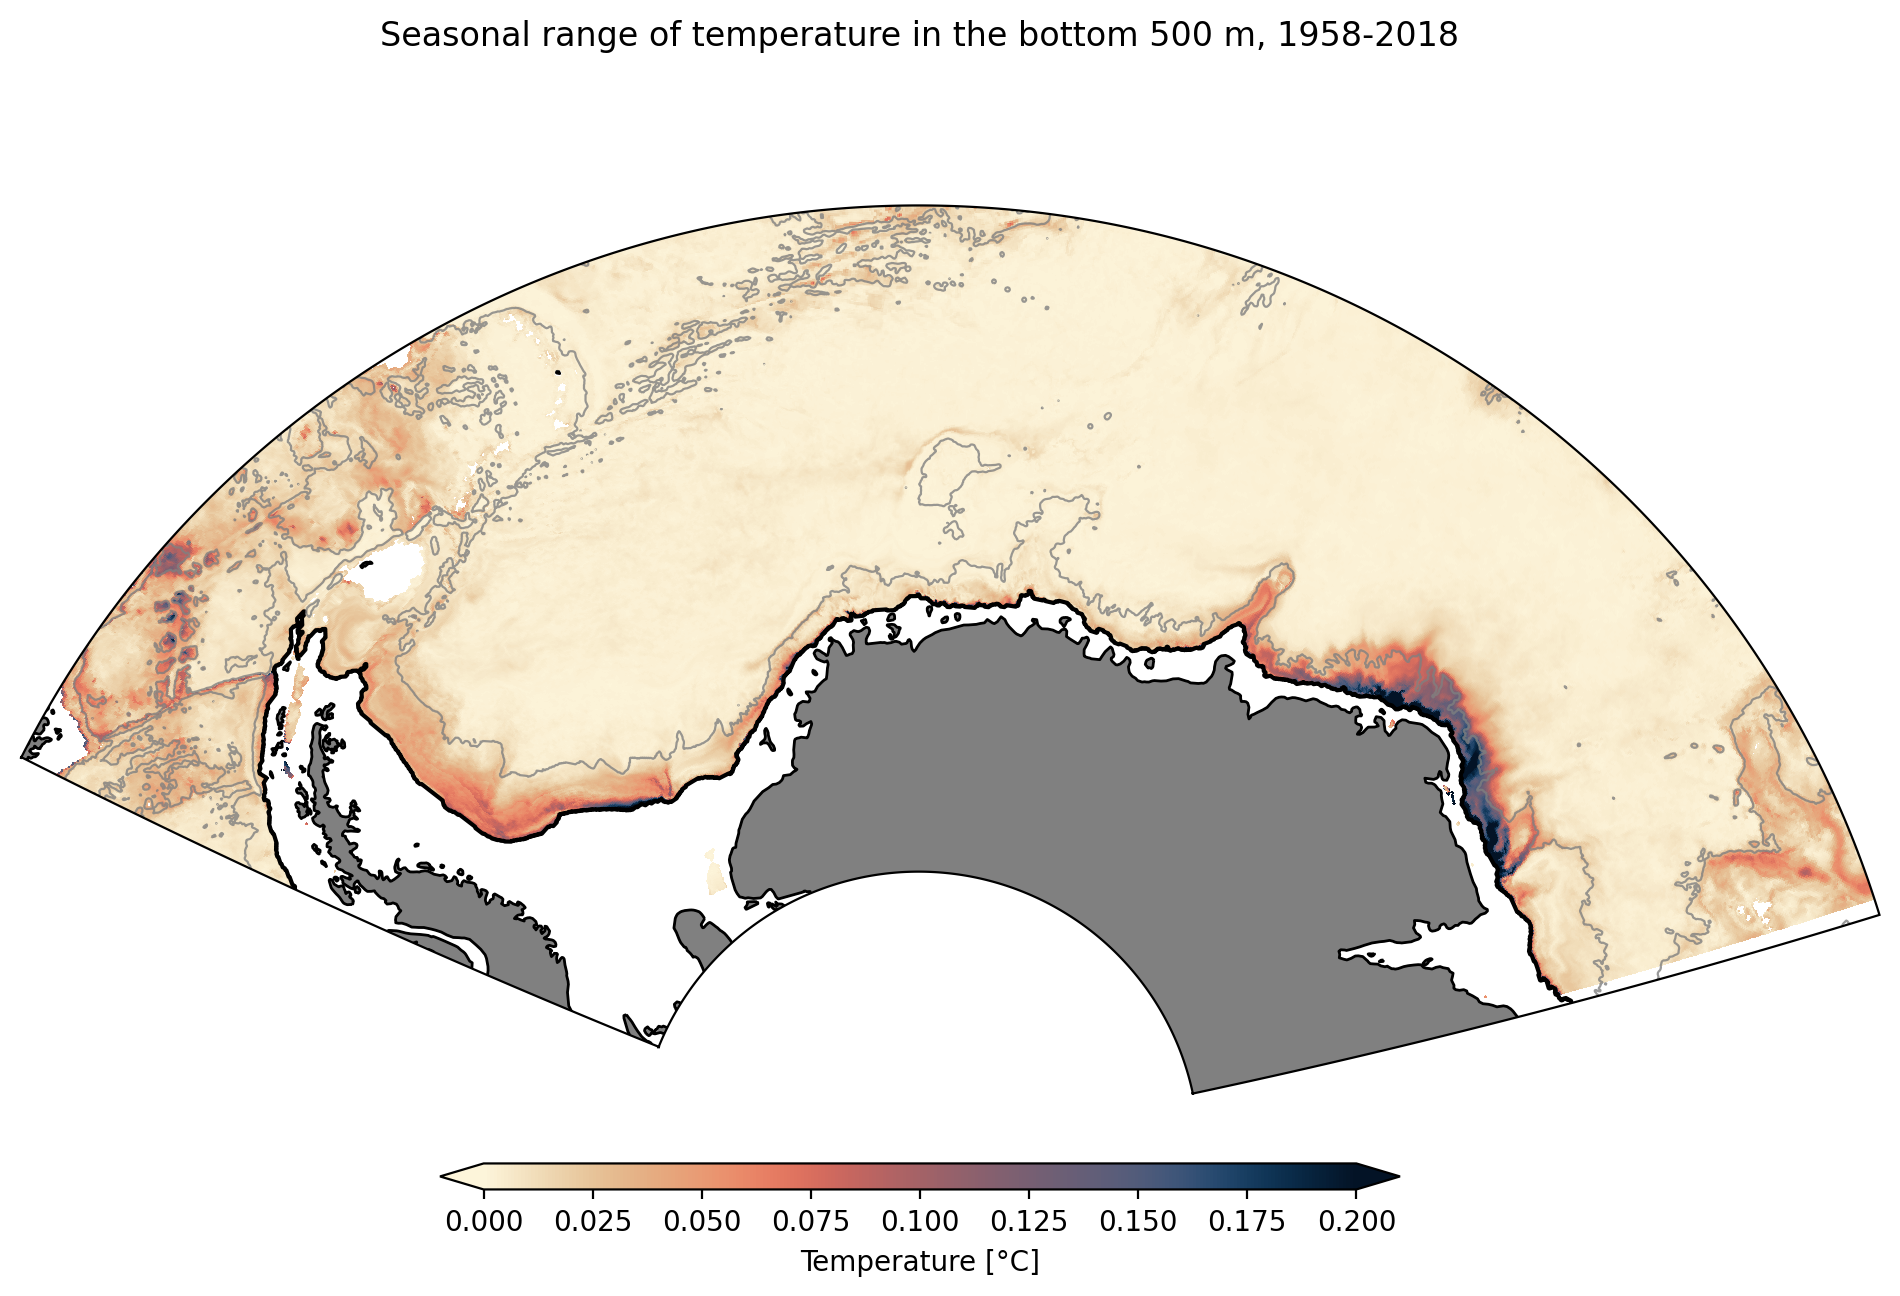

In [60]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80 
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

# To plot 1000-m contour
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf[np.where(shelf!=0)] = np.nan
shelf = shelf+1
shelf = np.nan_to_num(shelf)
shelf = xr.DataArray(shelf, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])


ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.1, vmax=0.2)
cmap = cmcrameri.cm.lipari_r
pc = plt.pcolormesh(temp_range.xt_ocean+360, temp_range.yt_ocean, temp_range, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label(f'Temperature [{degree}C]')

plt.suptitle(f'Seasonal range of temperature in the bottom 500 m, {first_year}-{last_year}')

plt.savefig(f'{figdir}/bottom_temp_west_AA_range_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


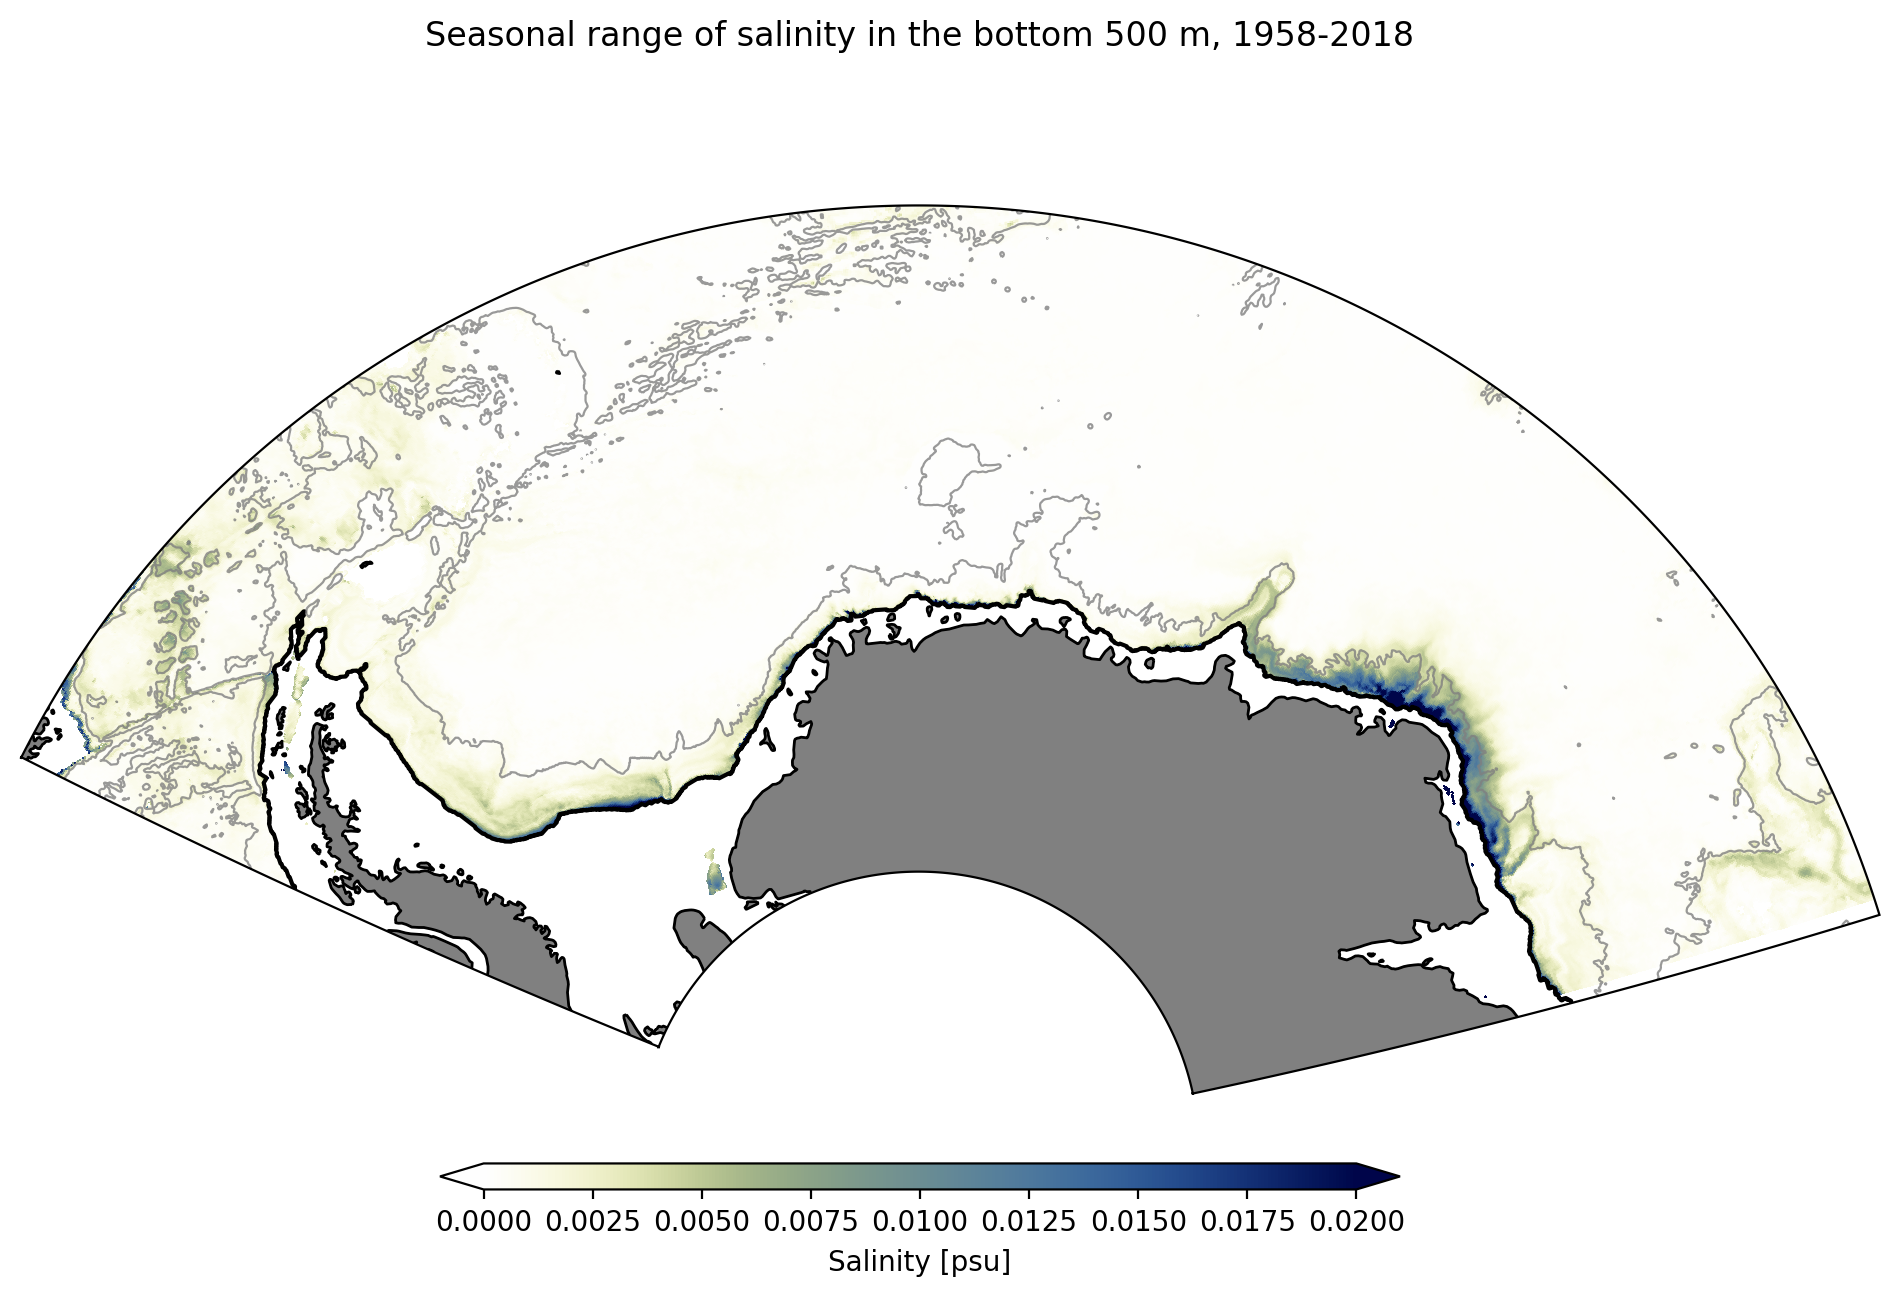

In [58]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
plt.suptitle('Salinity range')
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

# To plot 1000-m contour
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf[np.where(shelf!=0)] = np.nan
shelf = shelf+1
shelf = np.nan_to_num(shelf)
shelf = xr.DataArray(shelf, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])


ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.01, vmax=0.02)
cmap = cmcrameri.cm.davos_r
pc = plt.pcolormesh(salt_range.xt_ocean+360, salt_range.yt_ocean, salt_range, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('Salinity [psu]')
plt.suptitle(f'Seasonal range of salinity in the bottom 500 m, {first_year}-{last_year}')


plt.savefig(f'{figdir}/bottom_salinity_range_west_AA_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


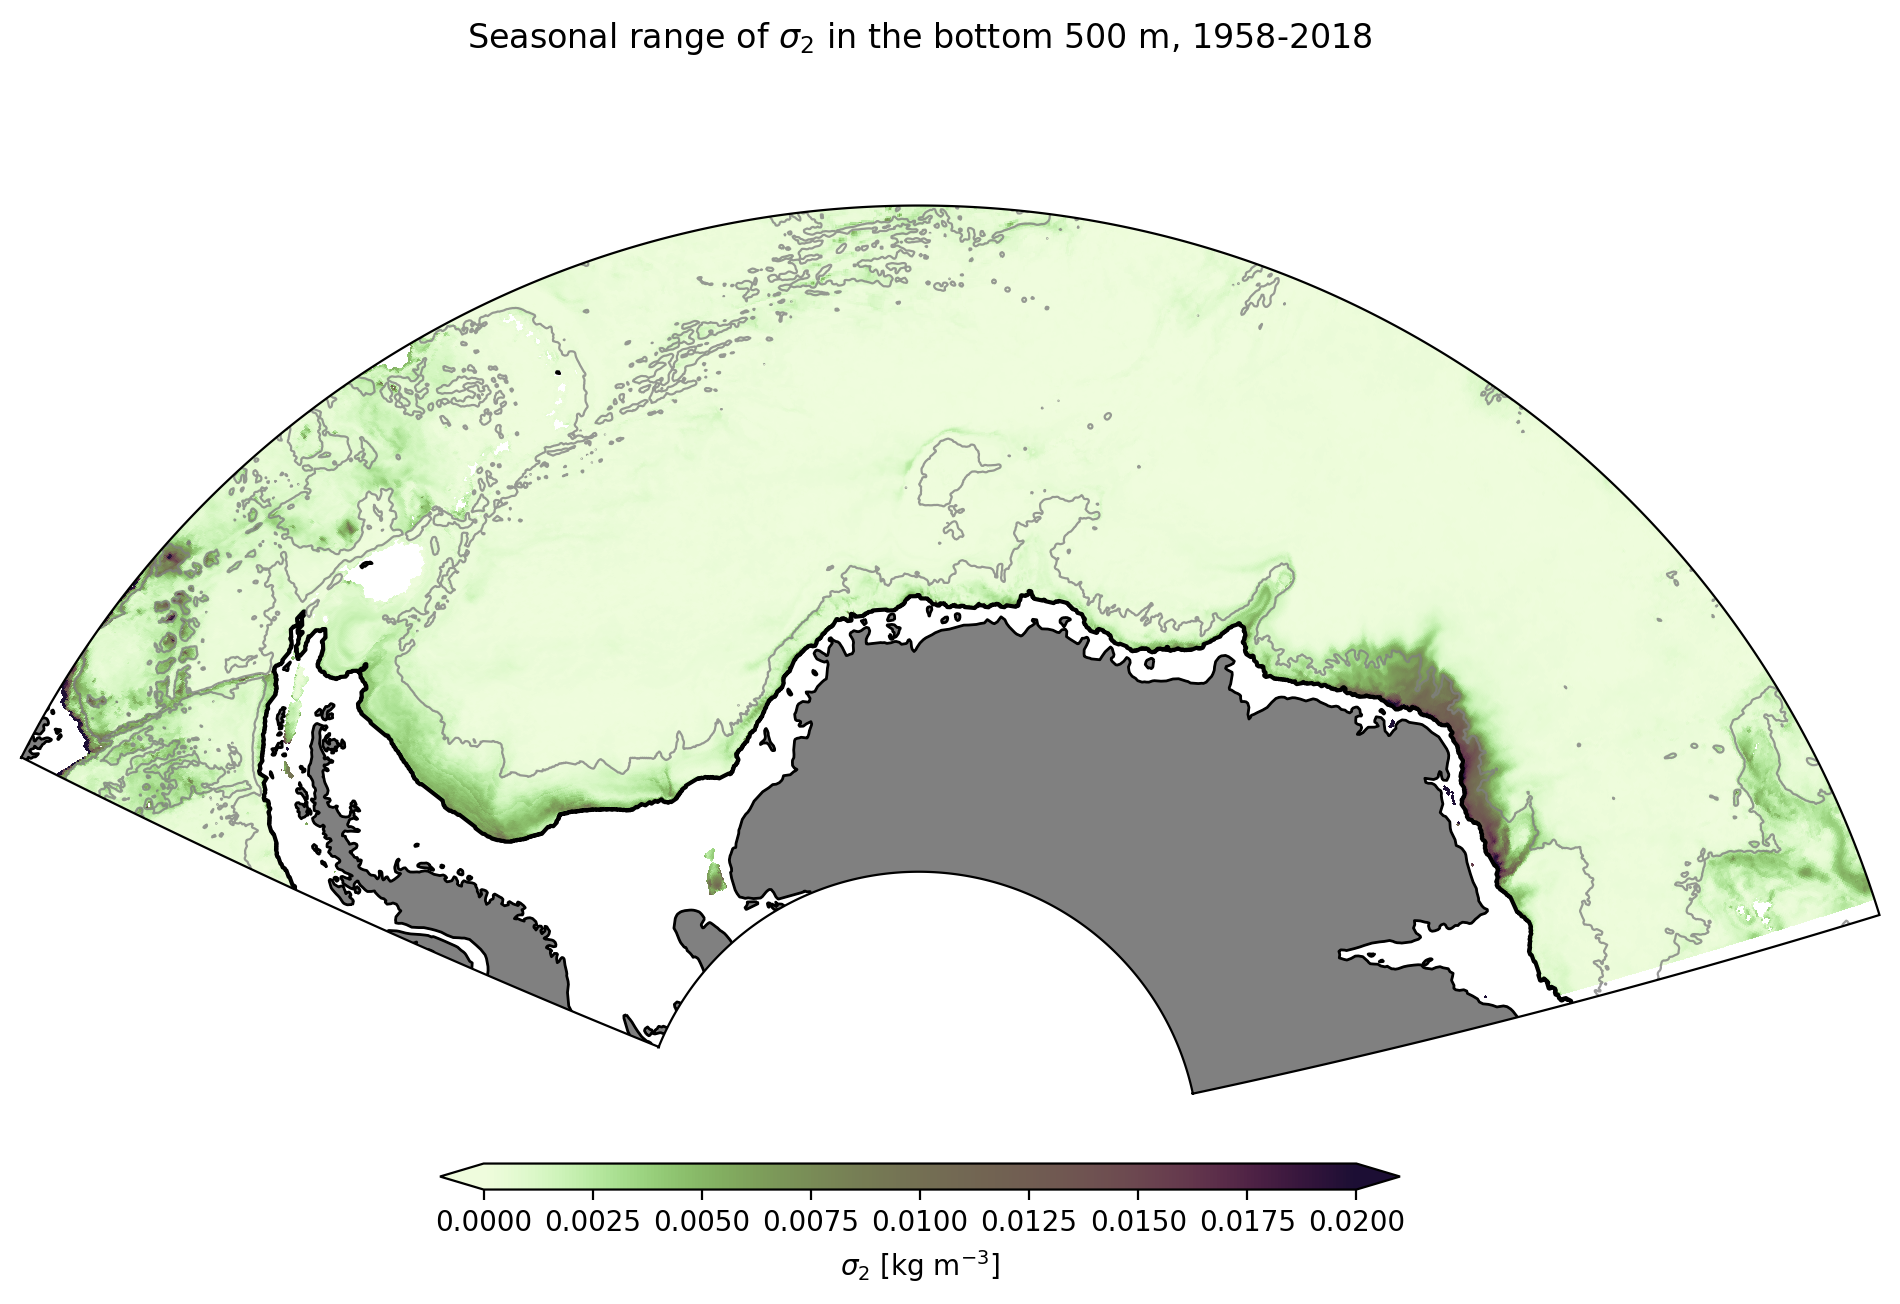

In [59]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
plt.suptitle('Density seasonal range')
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

# To plot 1000-m contour
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf[np.where(shelf!=0)] = np.nan
shelf = shelf+1
shelf = np.nan_to_num(shelf)
shelf = xr.DataArray(shelf, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])


ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.01, vmax=0.02)
cmap = cmcrameri.cm.tokyo_r
pc = plt.pcolormesh(sigma2_range.xt_ocean+360, sigma2_range.yt_ocean, sigma2_range, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('$\sigma_2$ [kg m$^{-3}$]')
plt.suptitle(f'Seasonal range of $\sigma_2$ in the bottom 500 m, {first_year}-{last_year}')


plt.savefig(f'{figdir}/sigma_2_range_west_AA_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


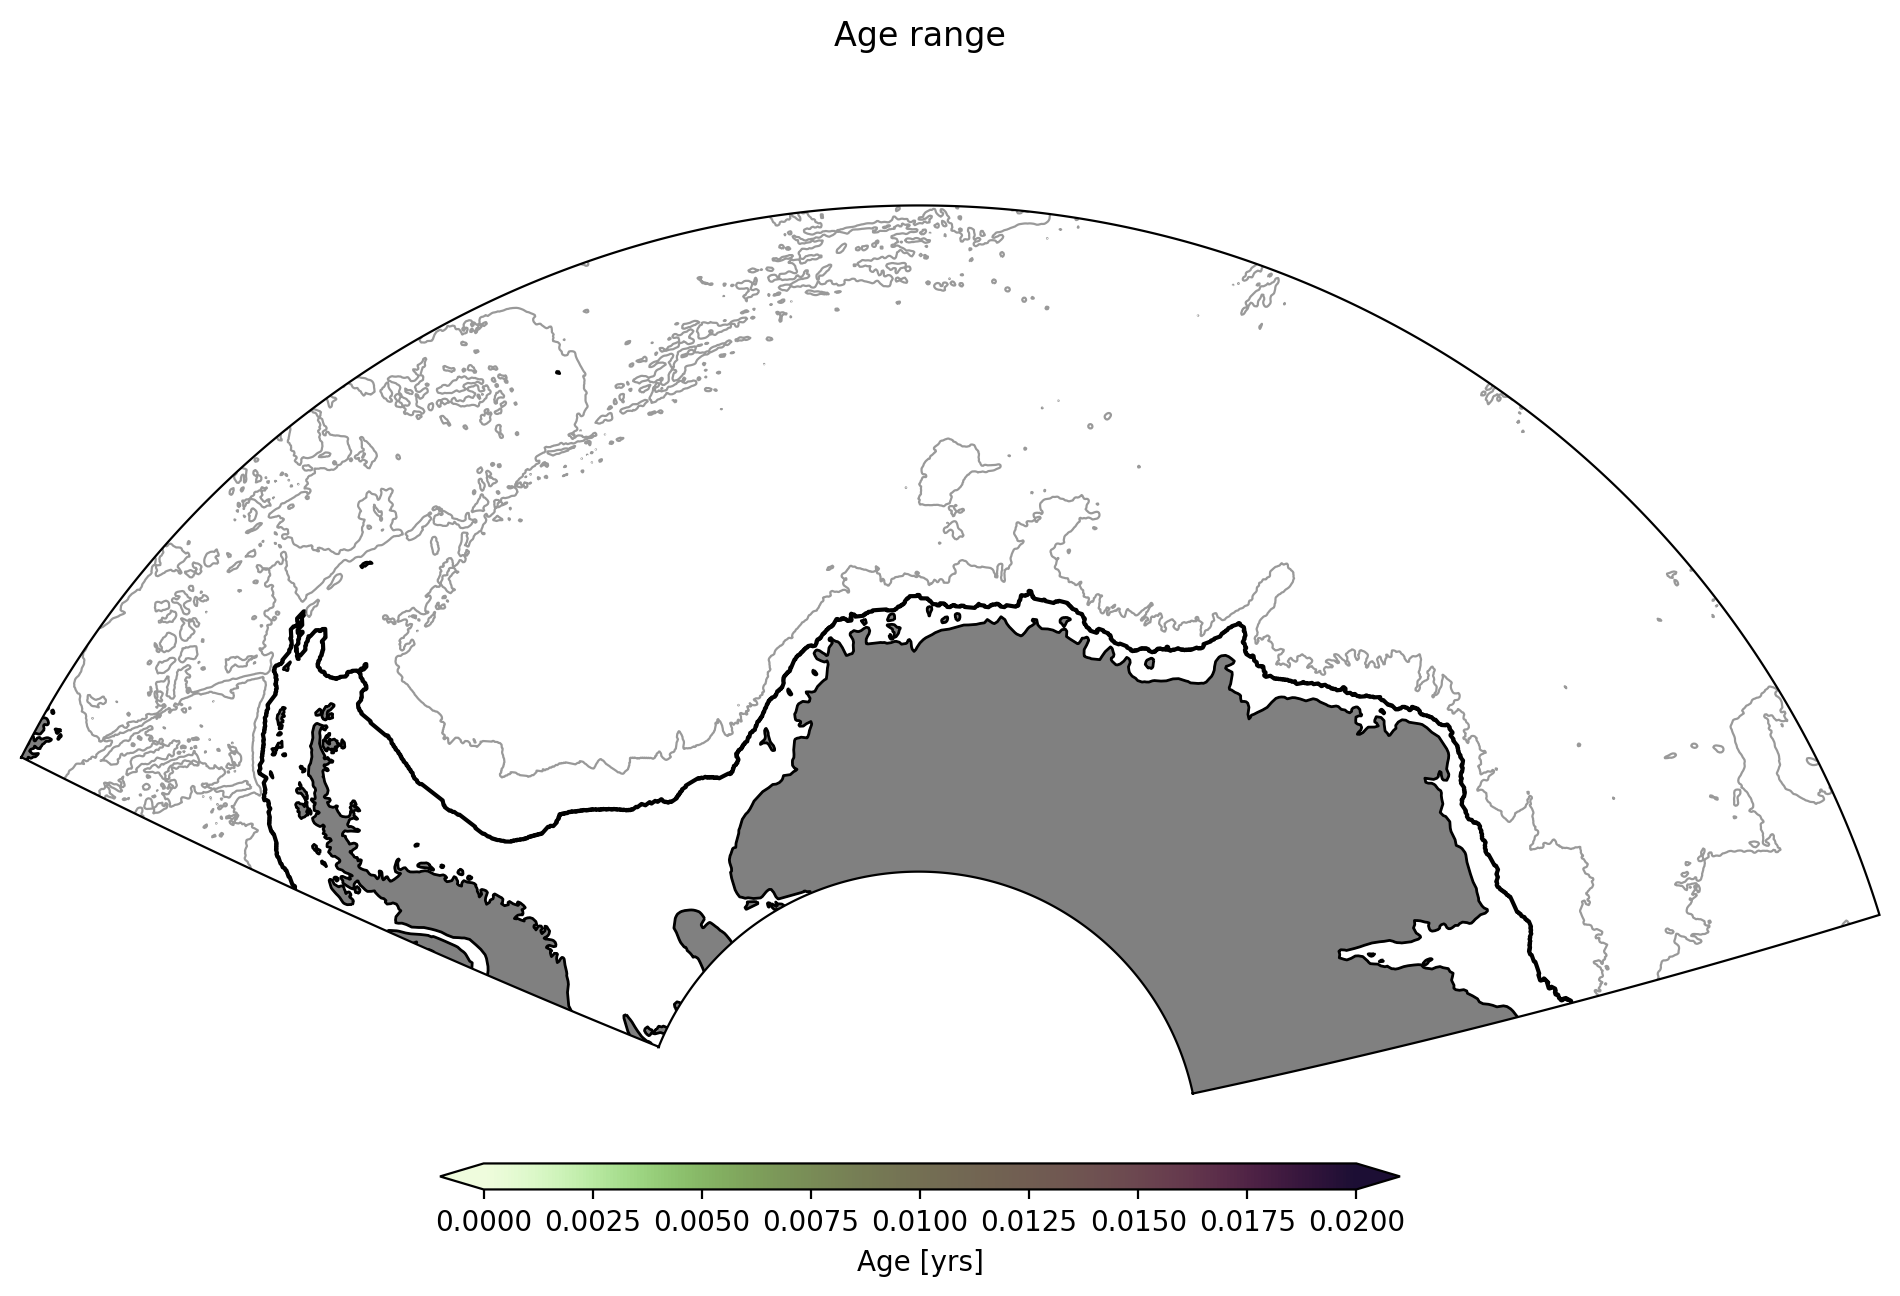

In [48]:
midlon = 0
maxlon = midlon + 80
minlon = midlon - 70
minlat = -80
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
plt.suptitle('Age range')
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

# To plot 1000-m contour
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf[np.where(shelf!=0)] = np.nan
shelf = shelf+1
shelf = np.nan_to_num(shelf)
shelf = xr.DataArray(shelf, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])


ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

# norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=4, vmax=8)
cmap = cmcrameri.cm.tokyo_r
pc = plt.pcolormesh(age_range.xt_ocean+360, age_range.yt_ocean, age_range, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('Age [yrs]')

plt.savefig(f'{figdir}/bottom_age_range_west_AA_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')
